# Setup

In [ ]:
#@title Install Packages
!pip install diffusers==0.27 accelerate==0.28

In [ ]:
#@title Create the model { run: "auto" }
from diffusers import DDPMPipeline, DDIMPipeline
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_id = "google/ddpm-ema-church-256" #@param ["google/ddpm-ema-celebahq-256", "google/ddpm-ema-church-256", "google/ddpm-ema-bedroom-256"]

ddpm = DDPMPipeline.from_pretrained(model_id)
ddim = DDIMPipeline.from_pretrained(model_id)
unet = ddim.unet
# unet = unet.to(device)
scheduler = ddim.scheduler

number_of_sample = 1
shape = [number_of_sample, 3, 256, 256]
# random_seed = torch.randn(shape).to(device)
num_timesteps = int(ddpm.scheduler.betas.shape[0])
betas = ddpm.scheduler.betas
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)

from tqdm import tqdm

def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    try:
        res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    except:
        res = arr.to(device=timesteps.device)[timesteps].float()

    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


dynamic_threshol_ratio = 0.98
dynamic_threshold_max = 1.3

@torch.no_grad()
def langevin_sampling(inputs, model, t, t_prev, steps = 100, epsilon = 1e-5,min_variance = -1,
                     denoising_step = True, clip_prev = False, clip_now = False, dynamic_thresholding = False,  power  = 0.5,
                     clip_inputs = True, number_of_stds = 2, prev_pred = None):


    alphas_cumprod = ddpm.scheduler.alphas_cumprod.cpu().numpy()
    index = t
    t = torch.tensor([t] * inputs.shape[0]).to(device)
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    std = torch.sqrt(variance)
    std_epsilon = []
    mean_epsilon = []
    if t_prev is not None:
        t_prev = torch.tensor([t_prev] * inputs.shape[0]).to(device)
        mean_coef_t_prev = torch.sqrt(_extract_into_tensor(alphas_cumprod, t_prev , inputs.shape))
        variance_t_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_t_prev)
        if clip_inputs:
            inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred)
        noise_estimate_t_prev = model(inputs, t_prev)['sample']
        x0_t_1 = (inputs - std_prev * noise_estimate_t_prev)/mean_coef_t_prev
        if dynamic_thresholding:
            x0_t_1 = _threshold_sample(x0_t_1, dynamic_threshol_ratio, dynamic_threshold_max)
        if clip_prev:
            x0_t_1 = x0_t_1.clamp(-1,1)
        inputs = inputs + x0_t_1 * (mean_coef_t - mean_coef_t_prev)

    if min_variance > 0:
        alpha_coef =  (variance/min_variance) * epsilon
    else:
        alpha_coef = torch.ones_like(variance) * epsilon
    with torch.no_grad():
        for i in range(steps):
            if clip_inputs:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds,original_img = prev_pred)
            noise_estimate = model(inputs, t)['sample']
            if dynamic_thresholding:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = _threshold_sample(x0_t, dynamic_threshol_ratio, dynamic_threshold_max)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            elif clip_now:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = x0_t.clamp(-1,1)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            std_epsilon.append(noise_estimate[0].cpu().std().item())
            mean_epsilon.append(noise_estimate[0].cpu().mean().item())
            score = - noise_estimate / std
            noise = torch.randn(inputs.shape).to(device)
            if steps > 1:
                inputs = (inputs + alpha_coef * score) + torch.pow(2*alpha_coef, power) * noise
        if denoising_step:
            if clip_inputs:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred)
            noise_estimate = model(inputs, t)['sample']
            score = - noise_estimate / std
            inputs = (inputs + alpha_coef * score)
        x0_t = (inputs - std * noise_estimate)/mean_coef_t
    return inputs, alpha_coef, std_epsilon, mean_epsilon, x0_t

def _threshold_sample(sample: torch.FloatTensor, dynamic_thresholding_ratio: float, sample_max_value : float = 5/3) -> torch.FloatTensor:
    """
    "Dynamic thresholding: At each sampling step we set s to a certain percentile absolute pixel value in xt0 (the
    prediction of x_0 at timestep t), and if s > 1, then we threshold xt0 to the range [-s, s] and then divide by
    s. Dynamic thresholding pushes saturated pixels (those near -1 and 1) inwards, thereby actively preventing
    pixels from saturation at each step. We find that dynamic thresholding results in significantly better
    photorealism as well as better image-text alignment, especially when using very large guidance weights."

    https://arxiv.org/abs/2205.11487
    """
    dtype = sample.dtype
    batch_size, channels, *remaining_dims = sample.shape

    if dtype not in (torch.float32, torch.float64):
        sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half

    # Flatten sample for doing quantile calculation along each image
    sample = sample.reshape(batch_size, channels * np.prod(remaining_dims))

    abs_sample = sample.abs()  # "a certain percentile absolute pixel value"

    s = torch.quantile(abs_sample, dynamic_thresholding_ratio, dim=1)
    s = torch.clamp(
        s, min=1, max=sample_max_value
    )  # When clamped to min=1, equivalent to standard clipping to [-1, 1]
    s = s.unsqueeze(1)  # (batch_size, 1) because clamp will broadcast along dim=0
    sample = torch.clamp(sample, -s, s) / s  # "we threshold xt0 to the range [-s, s] and then divide by s"

    sample = sample.reshape(batch_size, channels, *remaining_dims)
    sample = sample.to(dtype)

    return sample

@torch.no_grad()
def _clip_inputs(sample: torch.FloatTensor, t : int, number_of_stds: float = 2., original_img = None):
    """
    Cliping the inputs with an confidence interval given by the diffusion schedule
    """
    dtype = sample.dtype
    batch_size, channels, *remaining_dims = sample.shape

    if dtype not in (torch.float32, torch.float64):
        sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half
    alpha_t = alphas_cumprod[t]
    sqrt_alpha_t = torch.sqrt(alpha_t).item()
    one_minus_sqrt_alpha_t = torch.sqrt(1-alpha_t).item()
    if original_img is None:
        confidence_interval = [-sqrt_alpha_t - number_of_stds * one_minus_sqrt_alpha_t, sqrt_alpha_t + number_of_stds * one_minus_sqrt_alpha_t]
    else:
        confidence_interval = [sqrt_alpha_t * original_img - number_of_stds * one_minus_sqrt_alpha_t,
                               sqrt_alpha_t * original_img + number_of_stds * one_minus_sqrt_alpha_t]

    sample = torch.clamp(sample, confidence_interval[0], confidence_interval[1])
    sample = sample.to(dtype)

    return sample

@torch.no_grad()
def ddim_step(inputs, model, t, alphas_cumprod = alphas_cumprod, clip_denoised = False, dynamic_thresholding = True,
              clip_value = 1, sigma = 0,
              number_of_timesteps = ddpm.scheduler.betas.shape[0], device = device,
              forward = True, clip_inputs = True, number_of_stds = 2,
            prev_pred = None):

    index = t
    model = model.to(device)
    if len(inputs.shape) < 4 :
        inputs = inputs.unsqueeze(0)
    if t > 0 and forward:
        t_prev = torch.tensor([t-1] * inputs.shape[0], device=device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)
    elif t < number_of_timesteps :
        t_prev = torch.tensor([t+1] * inputs.shape[0], device=device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)

    t = torch.tensor([t] * inputs.shape[0], device=device)
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    std = torch.sqrt(variance)
    if clip_inputs:
        if prev_pred is None:
            inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds)
        else:
            inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred)
    noise_estimate = model(inputs, t)['sample']
    std_epsilon = noise_estimate[0].cpu().std().item()
    mean_epsilon = noise_estimate[0].cpu().mean().item()
    if dynamic_thresholding:
        x0_t = (inputs - std * noise_estimate)/mean_coef_t
        x0_t = _threshold_sample(x0_t, 0.98, 1.3)
        noise_estimate = (inputs - mean_coef_t * x0_t) / std
        std_epsilon = noise_estimate[0].cpu().std().item()
        mean_epsilon = noise_estimate[0].cpu().mean().item()
    elif clip_denoised:
        x0_t = (inputs - std * noise_estimate)/mean_coef_t
        x0_t = x0_t.clamp(-1,1)
        noise_estimate = (inputs - mean_coef_t * x0_t) / std
        std_epsilon = noise_estimate[0].cpu().std().item()
        mean_epsilon = noise_estimate[0].cpu().mean().item()
    if sigma > 0:
        sigma_t = sigma * torch.sqrt((variance_prev)/(variance)) * torch.sqrt(1 - (1-variance)/ (1-variance_prev))
    else:
        sigma_t = 0.
    noise= torch.randn_like(inputs)
    x0_t = (inputs - std * noise_estimate)/mean_coef_t
    x_prev = torch.sqrt(1-variance_prev) / torch.sqrt(1-variance) * ((inputs - std * noise_estimate)) + torch.sqrt(variance_prev - sigma_t**2)  * noise_estimate + sigma_t * noise
    return x_prev, std_epsilon, mean_epsilon, x0_t

@torch.no_grad()
def editing_with_ode(latent_codes, model, t_start = 1000, annealing = 1, annealing_cst=0.9, epsilon = 1e-8,
                    steps = 20, power =0.5, min_variance = -1. , number_of_sample = 1,normalize=False,
                    corrector_step = 1, clip_inputs = True, number_of_stds = 3, prev_pred = None,
                    dynamic_thresholding_ddim = True,dynamic_thresholding_langevin = False ):

    alphas_cumprod = ddpm.scheduler.alphas_cumprod
    list_of_evolution_reverse = []
    final_samples = []
    t_valid = list(range(0, min(1000,t_start)))
    std_recon = 1
    if t_start > 99 + corrector_step and corrector_step > 1:
        correction_latents = np.linspace(99, np.max(t_valid), corrector_step).astype(int).tolist()
        epsilon_correction = np.geomspace(1,300,1000)[::-1]
        epsilon_correction = epsilon_correction / epsilon_correction[np.max(t_valid)]
    else:
        correction_latents = [np.max(t_valid)]
    print(f"correction_latents {correction_latents}")
    with torch.no_grad():
        if normalize:
            inputs = (latent_codes[np.max(t_valid)] - latent_codes[np.max(t_valid)].mean([1,2,3]))/latent_codes[np.max(t_valid)].std([1,2,3])
        else:
            inputs = latent_codes[np.max(t_valid)]
        if len(inputs.shape) == 3:
            inputs = inputs.unsqueeze(0)
            batch_size = 1
        elif len(inputs.shape) == 4:
            batch_size = inputs.shape[0]
        else:
            raise NotImplementedError

        if batch_size > 1 and number_of_sample > 1:
            inputs = inputs.split(1, dim=0)
            inputs = [inp.repeat(number_of_sample, 1, 1, 1) for inp in inputs]
            inputs = torch.cat(inputs)
        if prev_pred is not None:
            prev_pred = prev_pred.split(1,dim=0)
            prev_pred = [inp.repeat(number_of_sample, 1, 1, 1) for inp in prev_pred]
            prev_pred = torch.cat(prev_pred)

        elif number_of_sample > 1:
            inputs = inputs.repeat(number_of_sample, 1, 1, 1)
        else:
            inputs = inputs

        x0_t = prev_pred

        inputs = inputs.to(device)

        if True:
            for t in tqdm(t_valid[::-1]):
                if t == np.max(t_valid):
                    before = inputs.cpu()
                    if annealing>1:
                        new_epsilon = epsilon
                        for j in range(int(annealing)):
                            step_per_epsilon = steps // len(range(int(annealing)))
                            inputs,alpha_coef, list_of_stds, list_of_means, x0_t = langevin_sampling(inputs,model, t,
                                                                                    None, steps = step_per_epsilon, epsilon = new_epsilon,
                                                                                    min_variance = min_variance, clip_prev = False,
                                                                                    clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                                                    clip_inputs = clip_inputs, number_of_stds = number_of_stds,
                                                                                    power = power,prev_pred = x0_t)
                            new_epsilon  = new_epsilon * annealing_cst

                    else:
                        inputs,alpha_coef, list_of_stds, list_of_means, x0_t = langevin_sampling(inputs,model, t,
                                                                    None, steps = steps, epsilon = epsilon,
                                                                    min_variance = min_variance, clip_prev = False,
                                                                    clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                                    clip_inputs = clip_inputs, number_of_stds = number_of_stds,
                                                                    power = power, prev_pred = x0_t)

                    for h in range(len(inputs)):
                            list_of_evolution_reverse.append(inputs[h].cpu())

                elif t in correction_latents:
                    before = inputs.cpu()
                    epsilon_t = epsilon * epsilon_correction[t]
                    if annealing>1:
                        new_epsilon = epsilon_t
                        for j in range(int(annealing)):
                            step_per_epsilon = steps // len(range(int(annealing)))
                            inputs,alpha_coef, list_of_stds, list_of_means, x0_t = langevin_sampling(inputs,model, t,
                                                                    None, steps = step_per_epsilon, epsilon = new_epsilon,
                                                                    min_variance = min_variance, clip_prev = False,
                                                                    clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                                    clip_inputs = clip_inputs, number_of_stds = number_of_stds,
                                                                    power = power)
                            new_epsilon  = new_epsilon * annealing_cst
                    else:
                        inputs,alpha_coef, _, _, _ = langevin_sampling(inputs,model, t,
                                                                        None, steps = steps, epsilon = epsilon_t,
                                                                        min_variance = min_variance, clip_prev = False,
                                                                        clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                                        clip_inputs = clip_inputs, number_of_stds = number_of_stds,
                                                                        power = power)

                    for h in range(len(inputs)):
                            list_of_evolution_reverse.append(inputs[h].cpu())


                inputs, _, _, x0_t = ddim_step(inputs, ddpm.unet, t, sigma = 0.,
                                                        clip_denoised=False,dynamic_thresholding=dynamic_thresholding_ddim,  forward=True,
                                                        clip_inputs = clip_inputs, number_of_stds = number_of_stds,prev_pred = x0_t)

                if prev_pred is None:
                    x0_t = None

                for h in range(len(inputs)):
                    list_of_evolution_reverse.append(inputs[h].cpu())
            for sample in list_of_evolution_reverse[-batch_size*number_of_sample:]:
                final_samples.append(sample)

        for h in range(len(inputs)):
            list_of_evolution_reverse.append(inputs[h].cpu())
    return list_of_evolution_reverse, final_samples

# Guided Generation

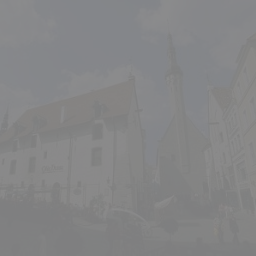

In [3]:
#@title Image choice { run: "auto" }

import ipywidgets as widgets
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# Specify your folder path here
folder_path = f'/content/imgs/{model_id}'

img_name = "contrast.png"#@param ["fog.png", "contrast.png"]

from PIL import Image

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor()
])

img = Image.open(f"/content/imgs/{model_id}/{img_name}")
img_tensor = transform(img) * 2 - 1
img

In [23]:
#@title Choose Generation Parametes { run: "auto" }

#@markdown **How many audio clips to create**
batch_size =  1#@param {type:"number"}

#@markdown **How many Langevin Steps to do**
#@markdown > The more steps you do, the better is the algorithm convergence. \
#@markdown > We suggest to set it to a value of 1000 for better convergence or 200 for faster generation
langevin_steps =  1000#@param {type:"number"}

#@markdown **Which latent space to update in**
#@markdown > The latent space choice depends on the type of changes you want to apply on the input image. \
#@markdown > For corruption types as *gaussian_blur* and *speckle_noise* we are interested in adding fine-grained details so it's best to use a shallow latent space for the updates (e.g. 200). \
#@markdown > For corruptions such as *fog* and *contrast* the changes are harder to recover because they include large whole-image color variations and masking, thus it's advised to use deeper latents (e.g. 1000).
latent = 1000#@param {type:"number"}

#@markdown **The epsilon step size to take at each langevin step**
#@markdown > Changes in deeper latent spaces are more delicate to deal with, so using small values for epsilon is advised to avoid diverging too much from the input (e.g. in a range 1e-4 to 1e-6). \
#@markdown > For shallower latent spaces a larger value (e.g. in a range 1e-2 to 1e-4) is advised. \
epsilon = 1.15e-5# @param {type:"number"}

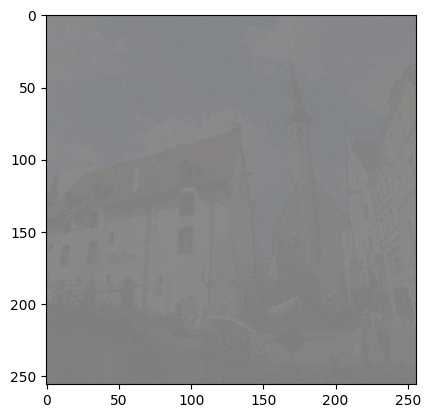

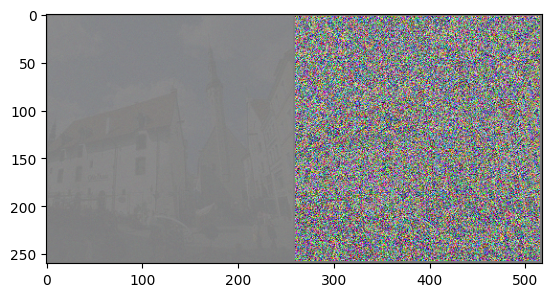

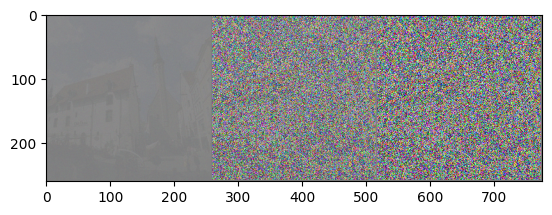

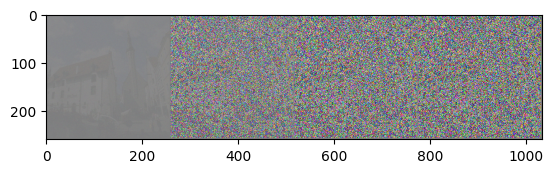

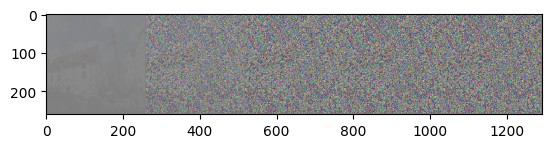

In [5]:
#@title Run DDIM Inversion
#@markdown This cell runs the DDIM inversion which to bring back the image into the desired latent space, which is a prerequisite for ODEdit.
#@markdown > **_NOTE_**: No need to run this cell again if you didn't change the model or the image

inputs = img_tensor.squeeze().to(device) + 0.01 * torch.randn_like(img_tensor).to(device)
list_of_evolution = []
list_std_encoding = []
list_mean_encoding = []

latent_codes = []
with torch.no_grad():
    latent_codes.append(inputs)
    x0_t = img_tensor.squeeze().to(device)
    for t in range(0,ddpm.scheduler.betas.shape[0]-1):
        inputs, std_eps, mean_eps, x0_t = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0., clip_denoised=False,
                                                dynamic_thresholding = True, device = device, forward=False,
                                                clip_inputs = False, number_of_stds = 2., prev_pred = None)
        latent_codes.append(inputs)
        list_std_encoding.append(std_eps)
        list_mean_encoding.append(mean_eps)
        if t % 200 ==0:
            for i in inputs:
                list_of_evolution.append(i.cpu())
            plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
            plt.show()
    for i in inputs:
        list_of_evolution.append(i.cpu())

correction_latents [99, 999]


100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


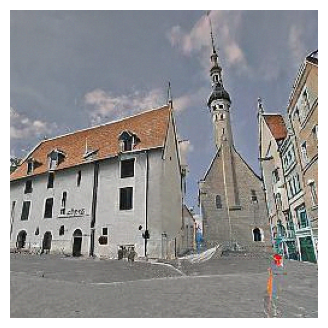

In [24]:
#@title Run ODEdit
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(12)

list_of_evolution_reverse, samples = editing_with_ode(latent_codes, ddpm.unet, t_start = latent, epsilon = epsilon, steps = langevin_steps, power=0.5,
                number_of_sample = batch_size, annealing = 10, annealing_cst = 0.8, corrector_step = 2, clip_inputs = False,
                number_of_stds = 3, prev_pred = None, dynamic_thresholding_langevin = False,
                dynamic_thresholding_ddim = True)
plt.figure(figsize=[4*batch_size,4])
plt.imshow(make_grid(torch.stack(list_of_evolution_reverse[-batch_size:]).cpu()).permute(1,2,0).cpu()/2+0.5)
plt.axis("off")
#plt.savefig(f"/home/martorel/dev/sketches/odedit_castle_new_{t_start}_{epsilon:.10f}.png")
plt.show()